### Objetivo

Este notebook possui uma **análise descritiva** da base de Câncer de Mama (Quimioterapia) junto com as bases agregadas por municípios usando o script `src/handle_database.py`. Este script agrega os dados de Estabelecimentos, Equipes, Recursos Físicos e Recursos Humanos. Em seguida, nós juntamos a base de Câncer de Mama com essas bases agregadas. A ideia principal é avaliar o contexto no qual o paciente está inserido. Por exemplo, uma mulher de 40 anos que mora em Araraquara e não teve diagnóstico tardio possui quais recursos a disposição em sua cidade? Essa e outras perguntas iremos responder neste notebook.

No final do notebook, vamos gerar uma base pronta para ser utilizada em uma **análise preditiva**, onde usaremos aplicaremos um modelo de Regressão Logística (que não ficou bom) e um modelo LightGBM (usado como referência na apresentação).

Ambas as análises anteriores nos deram insights para construir uma **análise prescritiva** a qual será organizada no ppt em `report/`.

### Libs

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
sns.set()

In [4]:
palette = sns.color_palette("ch:2.5,-.1,dark=.1")

### Gera amostra aleatória

A quantidade de dados de Câncer de Mama possui quase 8 milhões de registros. Para simplificar a análise e o tempo de execução das células desde notebook, vamos selecionar uma amostra aleatória de 400 mil registros dessa base e comparar a proporção de estadiamento dessa amostra.

***Obs: As próximas 5 células precisam ser executadas apenas 1 vez. Após isso, basta usar o sample `Mama_Quimioterapia_SIA-SUS_sample.csv`

In [5]:
df_qui_total = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/mama/Mama_Quimioterapia_SIA-SUS.csv',
    encoding='ISO-8859-1',
    index_col=0,
    low_memory=True
)

In [7]:
df_qui_total['tardio_base_original'] = df_qui_total['AQ_ESTADI'].apply(lambda x: 1 if x in [3, 4] else 0)

In [8]:
print(f"Proporção de diagnóstico tardio para câncer de Mama: {100 * df_qui_total.tardio_base_original.mean()}%")

Proporção de diagnóstico tardio para câncer de Mama: 39.894977005290656%


In [9]:
del df_qui_total['tardio_base_original']

In [9]:
df_qui_total.sample(400000).to_csv(
    '../data/Banco_Datathon/Banco_Datathon/mama/Mama_Quimioterapia_SIA-SUS_sample.csv'
)

### Carrega dataset do Câncer de Mama (Quimioterapia)

In [10]:
df_qui = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/mama/Mama_Quimioterapia_SIA-SUS_sample.csv',
    encoding='ISO-8859-1',
    index_col=0,
    low_memory=True
)

### Carrega bases agregadas (Recursos Humanos + Recursos Físicos + Estabelecimentos)

In [11]:
df_rh = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/processed/recursos_humanos.csv',
    index_col=0
)

df_rf = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/processed/recursos_fisicos.csv',
    index_col=0
)

df_est = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/processed/estabelecimentos.csv',
    index_col=0
)

df_equipes = pd.read_csv(
    '../data/Banco_Datathon/Banco_Datathon/processed/equipes.csv',
    index_col=0
)

In [12]:
print(df_qui.shape)
df_qui.head()

(400000, 63)


,AP_MVM,AP_CONDIC,AP_GESTAO,AP_CODUNI,AP_AUTORIZ,AP_CMP,AP_PRIPAL,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_CNPJCPF,AP_CNPJMNT,AP_CNSPCN,AP_COIDADE,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_CEPPCN,AP_UFDIF,AP_MNDIF,AP_DTINIC,AP_DTFIM,AP_TPATEN,AP_TPAPAC,AP_MOTSAI,AP_OBITO,AP_ENCERR,AP_PERMAN,AP_ALTA,AP_TRANSF,AP_DTOCOR,AP_CODEMI,AP_CATEND,AP_APACANT,AP_UNISOL,AP_DTSOLIC,AP_DTAUT,AP_CIDCAS,AP_CIDPRI,AP_CIDSEC,AP_ETNIA,AQ_CID10,AQ_LINFIN,AQ_ESTADI,AQ_GRAHIS,AQ_DTIDEN,AQ_TRANTE,AQ_CIDINI1,AQ_DTINI1,AQ_CIDINI2,AQ_DTINI2,AQ_CIDINI3,AQ_DTINI3,AQ_CONTTR,AQ_DTINTR,AQ_ESQU_P1,AQ_TOTMPL,AQ_TOTMAU,AQ_ESQU_P2
4234457,201610,PG,355030,2077590,3516237084789,201610,304020141,2828.40,355030,7,0,I,6.293294e+13,0.000000e+00,Â{|{|~ÂÂÂÂ,4,57,F,99,355030,10.0,3061040,0,1,20160811,20161031,3,2,15,0,0,0,1,0,20161031.0,M355030001,1,0.000000e+00,2077590,20160811.0,2.01608e+07,0000,C50- CÃ¢ncer de Mama,C500,NaN,NaN,3,0,01,20130801,0,NaN,NaN,NaN,NaN,NaN,NaN,S,20160509,FASLO,60,3,DEX
6001648,201708,PG,330455,2273462,3317202624197,201708,304050040,79.75,330455,7,0,M,3.945440e+11,3.945440e+11,Â{ÂÂ{~}{|Â}}ÂÂÂ,4,59,F,1,330455,10.0,20940000,0,1,20170719,20170930,3,2,21,0,0,1,0,0,NaN,M330455001,1,3.317201e+12,2273462,20170719.0,2.01707e+07,0,C50- CÃ¢ncer de Mama,0000,NaN,NaN,3,1,G1,20140807,0,NaN,NaN,NaN,NaN,NaN,NaN,S,20150219,anast,60,29,rozol
4903486,201706,PG,211130,2697696,2117200976935,201706,304020338,751.00,211130,7,0,M,5.292982e+12,5.292982e+12,|Â}}ÂÂÂÂÂ|{{{|Â,4,43,F,99,210650,10.0,65218000,0,1,20170401,20170630,3,2,15,0,0,0,1,0,20170630.0,M211130001,1,2.117201e+12,2697696,20170401.0,2.01706e+07,0,C50- CÃ¢ncer de Mama,0,NaN,C509,S,3,GX,20080717,S,C509,20080801.0,C509,20090831.0,NaN,NaN,S,20150402,ANAST,60,18,ROZOL+ ELI
4135124,201606,EP,350000,2081695,3516224825729,201606,304020338,301.50,355220,5,0,M,4.637450e+13,4.637450e+13,ÂÂÂ{{{Â~~ÂÂ~}|,4,91,F,3,355220,10.0,18103255,0,1,20160512,20160731,3,2,21,0,0,1,0,0,NaN,E350000023,1,0.000000e+00,2081695.0,20160512.0,2.01605e+07,0000,C50- CÃ¢ncer de Mama,0000,NaN,NaN,3,2,00,20090402,0,NaN,NaN,NaN,NaN,NaN,NaN,S,20060623,ANAST,81,81,RAZOLPAMID
7262530,201803,EP,350000,2079798,3518212442426,201803,304040193,79.75,350950,5,0,M,4.606843e+13,4.606843e+13,}{{ÂÂ|Â}{Â{{{Â,4,58,F,1,355240,10.0,13181240,0,1,20180220,20180430,3,2,21,0,0,1,0,0,NaN,E350000012,1,0.000000e+00,2079798,20180220.0,2.01802e+07,0000,C50- CÃ¢ncer de Mama,0000,NaN,NaN,N,3,03,20171010,0,NaN,NaN,NaN,NaN,NaN,NaN,S,20171130,INI4,60,3,NaN


In [13]:
print(df_rh.shape)
print(df_rf.shape)
print(df_est.shape)
print(df_equipes.shape)

(5597, 12)
(5597, 27)
(5597, 27)
(5597, 12)


### Nulos

In [14]:
null_count = df_qui.isna().sum()
null_percentage = round(100 * (null_count / len(df_qui)), 3)
null_tbl = pd.DataFrame(
    data=[null_count, null_percentage, df_qui.dtypes],
    index=['null_count', 'null_percentage', 'types']).T.sort_values(ascending=False, by='null_count'
)

In [15]:
null_tbl

,null_count,null_percentage,types
AP_ETNIA,399973,99.993,float64
AP_DTOCOR,381307,95.327,float64
AQ_CIDINI3,344869,86.217,object
AQ_DTINI3,314894,78.724,float64
AQ_CIDINI2,276936,69.234,object
AQ_CID10,262337,65.584,object
AQ_DTINI2,243361,60.84,float64
AQ_CIDINI1,209965,52.491,object
AQ_DTINI1,174021,43.505,float64
AQ_ESQU_P2,137474,34.369,object


Vemos que existem algumas variáveis que possuem muitos valores nulos. Etnia por exemplo possui 99% de nulos. Vamos eliminar as variáveis que possuem >0% de nulos, com exceção da `AP_UFNACIO` (<1% de nulos).

In [16]:
features_to_drop = null_tbl.loc[null_tbl.null_percentage > 0.0015].index.tolist()

In [17]:
features_to_drop

['AP_ETNIA',
 'AP_DTOCOR',
 'AQ_CIDINI3',
 'AQ_DTINI3',
 'AQ_CIDINI2',
 'AQ_CID10',
 'AQ_DTINI2',
 'AQ_CIDINI1',
 'AQ_DTINI1',
 'AQ_ESQU_P2',
 'AP_CNPJMNT',
 'AP_APACANT',
 'AP_DTAUT',
 'AP_DTSOLIC',
 'AP_UNISOL',
 'AQ_GRAHIS',
 'AP_CNPJCPF']

In [18]:
df_qui.drop(columns=features_to_drop, inplace=True)

### Construção da variável resposta (Estadiamento)

In [19]:
df_qui.AQ_ESTADI.value_counts()

2    140165
3    114970
1     91392
4     44460
0      9013
Name: AQ_ESTADI, dtype: int64

A variável resposta pode variar de 0 a 4, onde 0, 1 e 2 corresponde aos estágios menos avançados da doença e 3, 4 corresponde aos estágios mais avançados da doença. Vamos criar uma coluna binária contendo esta informação

In [20]:
df_qui['tardio'] = df_qui['AQ_ESTADI'].apply(lambda x: 1 if x in [3, 4] else 0)

In [21]:
print(f"Proporção de diagnóstico tardio para câncer de Mama: {100 * df_qui.tardio.mean()}%")

Proporção de diagnóstico tardio para câncer de Mama: 39.8575%


A proporção de estadiamento para essa amostragem (~400 Mil) ficou muito próxima da proporção de estadiamento para a base total (~8 M). Existem outras técnicas mais sofisticadas de sampling, porém vamos seguir com essa abordagem simples para este problema.

### Filtro de variáveis

Vamos olhar para cada uma das variáveis a fim de manter apenas as variáveis que possam ser preditoras de diagnótico tardio ou nos ajudar a encontrar recomendações acionáveis para a Abrale.

In [22]:
print(df_qui.shape)
df_qui.head()

(400000, 47)


,AP_MVM,AP_CONDIC,AP_GESTAO,AP_CODUNI,AP_AUTORIZ,AP_CMP,AP_PRIPAL,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_CNSPCN,AP_COIDADE,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_CEPPCN,AP_UFDIF,AP_MNDIF,AP_DTINIC,AP_DTFIM,AP_TPATEN,AP_TPAPAC,AP_MOTSAI,AP_OBITO,AP_ENCERR,AP_PERMAN,AP_ALTA,AP_TRANSF,AP_CODEMI,AP_CATEND,AP_CIDCAS,AP_CIDPRI,AP_CIDSEC,AQ_LINFIN,AQ_ESTADI,AQ_DTIDEN,AQ_TRANTE,AQ_CONTTR,AQ_DTINTR,AQ_ESQU_P1,AQ_TOTMPL,AQ_TOTMAU,tardio
4234457,201610,PG,355030,2077590,3516237084789,201610,304020141,2828.40,355030,7,0,I,Â{|{|~ÂÂÂÂ,4,57,F,99,355030,10.0,3061040,0,1,20160811,20161031,3,2,15,0,0,0,1,0,M355030001,1,0000,C50- CÃ¢ncer de Mama,C500,3,0,20130801,0,S,20160509,FASLO,60,3,0
6001648,201708,PG,330455,2273462,3317202624197,201708,304050040,79.75,330455,7,0,M,Â{ÂÂ{~}{|Â}}ÂÂÂ,4,59,F,1,330455,10.0,20940000,0,1,20170719,20170930,3,2,21,0,0,1,0,0,M330455001,1,0,C50- CÃ¢ncer de Mama,0000,3,1,20140807,0,S,20150219,anast,60,29,0
4903486,201706,PG,211130,2697696,2117200976935,201706,304020338,751.00,211130,7,0,M,|Â}}ÂÂÂÂÂ|{{{|Â,4,43,F,99,210650,10.0,65218000,0,1,20170401,20170630,3,2,15,0,0,0,1,0,M211130001,1,0,C50- CÃ¢ncer de Mama,0,S,3,20080717,S,S,20150402,ANAST,60,18,1
4135124,201606,EP,350000,2081695,3516224825729,201606,304020338,301.50,355220,5,0,M,ÂÂÂ{{{Â~~ÂÂ~}|,4,91,F,3,355220,10.0,18103255,0,1,20160512,20160731,3,2,21,0,0,1,0,0,E350000023,1,0000,C50- CÃ¢ncer de Mama,0000,3,2,20090402,0,S,20060623,ANAST,81,81,0
7262530,201803,EP,350000,2079798,3518212442426,201803,304040193,79.75,350950,5,0,M,}{{ÂÂ|Â}{Â{{{Â,4,58,F,1,355240,10.0,13181240,0,1,20180220,20180430,3,2,21,0,0,1,0,0,E350000012,1,0000,C50- CÃ¢ncer de Mama,0000,N,3,20171010,0,S,20171130,INI4,60,3,1


In [23]:
features_to_remove = [
    'AQ_ESTADI', # Já foi criada a variável resposta com base nessa coluna
    'AQ_LINFIN', # Indica que já houve diagnóstico tardio
    'AQ_ESQU_P1', # Indica que já houve diagnóstico tardio
    'AQ_TOTMPL', # Indica que já houve diagnóstico tardio
    'AQ_TOTMAU', # Indica que já houve diagnóstico tardio
    'AP_MOTSAI', # Indica que já houve diagnóstico tardio
    'AP_ENCERR', # Indica que já houve diagnóstico tardio
    'AP_PERMAN',# Indica que já houve diagnóstico tardio    
    'AP_GESTAO', # Variável de identificação
    'AP_CODUNI', # Variável de identificação
    'AP_AUTORIZ', # Variável de identificação
    'AP_CIDSEC', # Variável de identificação
    'AP_PRIPAL', # Variável de identificação
    'AP_CNSPCN', # Variável de identificação
    'AP_COIDADE', # Variável de identificação
    'AP_CEPPCN', # Variável de identificação
    'AP_CODEMI', # Variável de identificação
    'AP_CEPPCN', # Variável de identificação
    'AP_TRANSF', # As duas classes não apresentam diferença estatisticamente significativa
    'AP_TPATEN', # Todas as linhas são iguais
    'AP_CIDPRI', # Todas as linhas são iguais
    'AP_MVM', # Data
    'AP_CMP', # Data
    'AP_DTINIC', # Data
    'AP_DTFIM', # Data
    'AQ_DTINTR', # Data
    'AP_OBITO', # Indica que já houve diagnóstico tardio
    'AP_CONDIC' # Indica que já houve diagnóstico tardio
]

In [24]:
df_qui.drop(columns=features_to_remove, inplace=True)

In [25]:
print(df_qui.shape)
df_qui.head()

(400000, 20)


,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_UFDIF,AP_MNDIF,AP_TPAPAC,AP_ALTA,AP_CATEND,AP_CIDCAS,AQ_DTIDEN,AQ_TRANTE,AQ_CONTTR,tardio
4234457,2828.40,355030,7,0,I,57,F,99,355030,10.0,0,1,2,1,1,0000,20130801,0,S,0
6001648,79.75,330455,7,0,M,59,F,1,330455,10.0,0,1,2,0,1,0,20140807,0,S,0
4903486,751.00,211130,7,0,M,43,F,99,210650,10.0,0,1,2,1,1,0,20080717,S,S,1
4135124,301.50,355220,5,0,M,91,F,3,355220,10.0,0,1,2,0,1,0000,20090402,0,S,0
7262530,79.75,350950,5,0,M,58,F,1,355240,10.0,0,1,2,0,1,0000,20171010,0,S,1


| CAMPO     	| DESCRIÇÃO                                                               	|
|-----------	|-------------------------------------------------------------------------	|
| AP_UFMUN  	| Código da Unidade da Federação + Código do Município do Estabelecimento 	|
| AP_MUNPCN 	| Código da UF + Código do Município de Residência do paciente            	|

Os dois campos acima podem ser usados para vincularmos as bases de Municípios (Recursos Humanos + Recursos Físicos + Estabelecimentos). Como o dataset de Mama apresenta uma linha por **paciente**, vamos usar o campo `AP_MUNPCN` para realizar este vínculo. Dessa forma, teremos mais dados sobre a infraestrutura na qual o paciente está inserido. Em seguida, iremos testar a influência do contexto no diagnóstico tardio dos pacientes.

### Agregação da base de Câncer de Mama com Recursos Humanos + Recursos Físicos + Estabelecimentos + Equipes

In [26]:
df_rh.rename(columns={'cod_mun': 'AP_MUNPCN'}, inplace=True)
df_rf.rename(columns={'cod_mun': 'AP_MUNPCN'}, inplace=True)
df_est.rename(columns={'cod_mun': 'AP_MUNPCN'}, inplace=True)
df_equipes.rename(columns={'cod_mun': 'AP_MUNPCN'}, inplace=True)

In [27]:
df = pd.merge(df_qui, df_rh, how='left', on='AP_MUNPCN')
df = pd.merge(df, df_rf, how='left', on='AP_MUNPCN', suffixes=('', '_rf'))
df = pd.merge(df, df_est, how='left', on='AP_MUNPCN', suffixes=('', '_est'))
df = pd.merge(df, df_equipes, how='left', on='AP_MUNPCN', suffixes=('', '_equipes'))
df.drop(columns=['nome_mun_rf', 'nome_mun_est', 'nome_mun_equipes'], inplace=True)

In [28]:
print(df.shape)
df.head()

(400000, 91)


,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_UFDIF,AP_MNDIF,AP_TPAPAC,AP_ALTA,AP_CATEND,AP_CIDCAS,AQ_DTIDEN,AQ_TRANTE,AQ_CONTTR,tardio,nome_mun,rh_enfermeiros_2014,rh_enfermeiros_2015,rh_enfermeiros_2016,rh_enfermeiros_2017,rh_enfermeiros_2018,rh_medicos_2014,rh_medicos_2015,rh_medicos_2016,rh_medicos_2017,rh_medicos_2018,rf_leitos_2014,rf_leitos_2015,rf_leitos_2016,rf_leitos_2017,rf_leitos_2018,rf_mamografos_2014,rf_mamografos_2015,rf_mamografos_2016,rf_mamografos_2017,rf_mamografos_2018,rf_raios_x_2014,rf_raios_x_2015,rf_raios_x_2016,rf_raios_x_2017,rf_raios_x_2018,rf_ressonancia_mag_2014,rf_ressonancia_mag_2015,rf_ressonancia_mag_2016,rf_ressonancia_mag_2017,rf_ressonancia_mag_2018,rf_tomografos_comp_2014,rf_tomografos_comp_2015,rf_tomografos_comp_2016,rf_tomografos_comp_2017,rf_tomografos_comp_2018,est_cli_amb_esp_max_2014,est_cli_amb_esp_max_2015,est_cli_amb_esp_max_2016,est_cli_amb_esp_max_2017,est_cli_amb_esp_max_2018,hosp_esp_max_2014,hosp_esp_max_2015,hosp_esp_max_2016,hosp_esp_max_2017,hosp_esp_max_2018,hop_geral_max_2014,hop_geral_max_2015,hop_geral_max_2016,hop_geral_max_2017,hop_geral_max_2018,ubs_max_2014,ubs_max_2015,ubs_max_2016,ubs_max_2017,ubs_max_2018,diagnose_e_terapia_max_2014,diagnose_e_terapia_max_2015,diagnose_e_terapia_max_2016,diagnose_e_terapia_max_2017,diagnose_e_terapia_max_2018,equipes_saude_da_familia_2014,equipes_saude_da_familia_2015,equipes_saude_da_familia_2016,equipes_saude_da_familia_2017,equipes_saude_da_familia_2018,equipes_nucleos_de_apoio_saude_da_familia_2014,equipes_nucleos_de_apoio_saude_da_familia_2015,equipes_nucleos_de_apoio_saude_da_familia_2016,equipes_nucleos_de_apoio_saude_da_familia_2017,equipes_nucleos_de_apoio_saude_da_familia_2018
0,2828.40,355030,7,0,I,57,F,99,355030,10.0,0,1,2,1,1,0000,20130801,0,S,0,São Paulo,18275.0,19692.0,20508.0,21273.0,22376.0,36244.0,37413.0,39489.0,40380.0,41820.0,15238.0,15724.0,15710.0,15174.0,15262.0,71.0,65.0,61.0,64.0,65.0,677.0,680.0,685.0,700.0,712.0,32.0,33.0,33.0,46.0,50.0,63.0,66.0,65.0,78.0,87.0,2377.0,2758.0,3249.0,3705.0,4190.0,52.0,52.0,50.0,51.0,51.0,147.0,151.0,148.0,148.0,151.0,572.0,571.0,498.0,498.0,499.0,664.0,663.0,683.0,786.0,869.0,835.0,788.0,817.0,799.0,887.0,98.0,89.0,100.0,127.0,130.0
1,79.75,330455,7,0,M,59,F,1,330455,10.0,0,1,2,0,1,0,20140807,0,S,0,Rio de Janeiro,11414.0,11957.0,12493.0,13023.0,13548.0,20795.0,20484.0,21185.0,22177.0,21878.0,11530.0,10955.0,10450.0,9873.0,9354.0,30.0,28.0,29.0,27.0,27.0,400.0,380.0,415.0,420.0,423.0,18.0,19.0,21.0,22.0,25.0,46.0,46.0,46.0,45.0,49.0,1763.0,1659.0,1686.0,1874.0,2097.0,104.0,77.0,78.0,77.0,69.0,151.0,122.0,121.0,129.0,129.0,248.0,245.0,274.0,287.0,309.0,717.0,571.0,577.0,570.0,606.0,392.0,388.0,517.0,597.0,596.0,58.0,74.0,73.0,77.0,77.0
2,751.00,211130,7,0,M,43,F,99,210650,10.0,0,1,2,1,1,0,20080717,S,S,1,Matinha,9.0,14.0,13.0,16.0,15.0,15.0,11.0,12.0,13.0,9.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,5.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0
3,301.50,355220,5,0,M,91,F,3,355220,10.0,0,1,2,0,1,0000,20090402,0,S,0,Sorocaba,575.0,634.0,659.0,678.0,728.0,1594.0,1633.0,1678.0,1769.0,1866.0,1982.0,1456.0,1217.0,983.0,883.0,8.0,8.0,8.0,8.0,8.0,41.0,42.0,45.0,45.0,47.0,1.0,1.0,2.0,2.0,4.0,6.0,7.0,6.0,5.0,6.0,54.0,57.0,62.0,68.0,80.0,7.0,7.0,6.0,4.0,4.0,7.0,7.0,7.0,7.0,8.0,35.0,34.0,35.0,36.0,36.0,75.0,78.0,80.0,85.0,91.0,39.0,38.0,41.0,42.0,43.0,0.0,0.0,0.0,2.0,3.0
4,79.75,350950,5,0,M,58,F,1,355240,10.0,0,1,2,0,1,0000,20171010,0,S,1,Sumaré,181.0,205.0,222.0,215.0,215.0,163.0,169.0,191.0,194.0,201.0,180.0,172.0,172.0,172.0,172.0,3.0,4.0,4.0,4.0,4.0,16.0,18.0,20.0,20.0,21.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,4.0,11.0,13.0,13.0,19.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,25.0,25.0,25.0,25.0,25.0,20.0,22.0,24.0,24.0,23.0,7.0,9.0,10.0,10.0,9.0,1.0,2.0,2.0,2.0,2.0


Este dataset será o dataset a ser analisado nas próximas células deste notebook.

### Análise Exploratória

### Função para plot de distribuições de variáveis contínuas

In [29]:
def plot_distplot(df, feature, title, target, target_names, target_colors, log10=False):
    df = df.copy()
    feature_name = feature
    positive_target = df[target] == 1
    negative_target = df[target] == 0

    if log10:
        feature_name = f'log_{feature}'
        df[feature] = df[feature].replace(0, 1)
        df[feature] = df[feature].astype(float)
        df[feature_name] = np.log10(df[feature])

    sns.distplot(df.loc[positive_target, feature_name], hist=False, label='1', color=target_colors[0])
    sns.distplot(df.loc[negative_target, feature_name], hist=False, label='0', color=target_colors[1])
    _ = plt.legend(target_names)
    _ = plt.title(title)

#### `AP_SEXO`

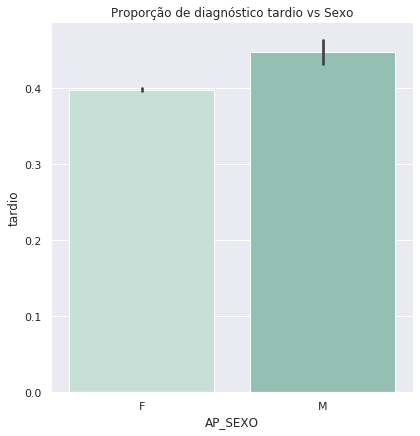

In [30]:
sns.catplot(
    y='tardio', 
    x='AP_SEXO', 
    kind='bar', 
    data=df, 
    height=6,
    palette=palette
)

plt.title('Proporção de diagnóstico tardio vs Sexo');

Vemos que o diagnóstico tardio de câncer de Mama é mais frequente nos homens do que nas mulheres. Os homens representam menos de 1% dos casos de Câncer de Mama dessa amostragem de dados.

In [31]:
df.AP_SEXO.value_counts(normalize=True) * 100

F    99.0595
M     0.9405
Name: AP_SEXO, dtype: float64

#### `AP_UFDIF`

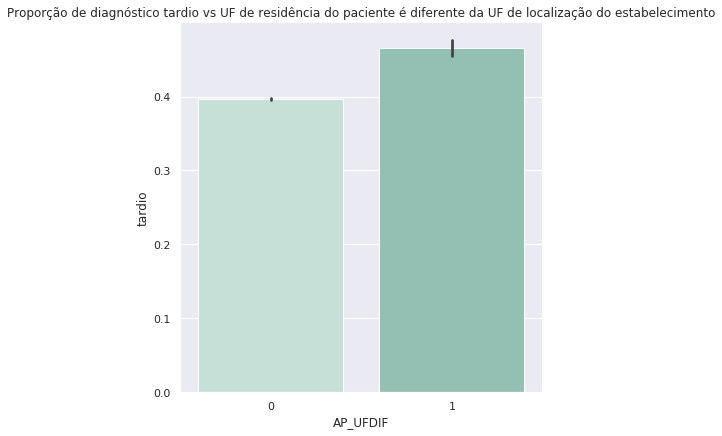

In [32]:
g = sns.catplot(
    y='tardio', 
    x='AP_UFDIF', 
    kind='bar', 
    data=df, 
    height=6,
    color='Greens_r',
    palette=palette
)
plt.title('Proporção de diagnóstico tardio vs UF de residência do paciente é diferente da UF de localização do estabelecimento');

In [33]:
df.AP_UFDIF.value_counts(normalize=True) * 100

0    97.99225
1     2.00775
Name: AP_UFDIF, dtype: float64

Quanto a UF de residência do paciente, vemos que a proporção de diagnóstico tardio é maior. Este caso ocorre para cerca de 2% do dataset.

#### `AP_MNDIF`

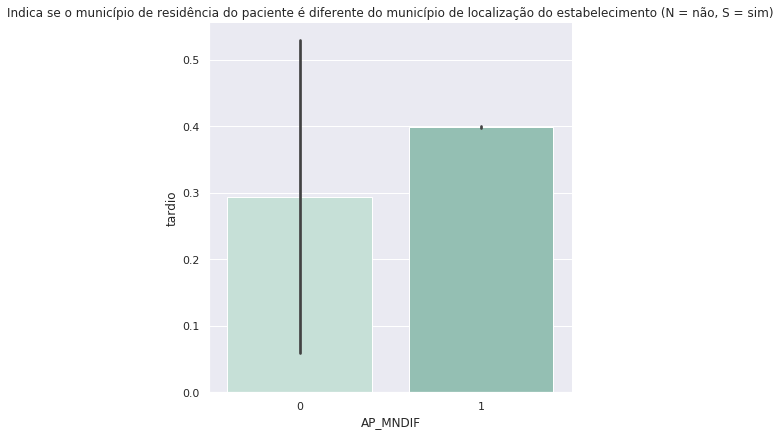

In [34]:
sns.catplot(
    y='tardio', 
    x='AP_MNDIF', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Indica se o município de residência do paciente é diferente do município de localização do estabelecimento (N = não, S = sim)');

Dado que o intervalo de confiança está muito alto para a classe 0, não vamos usar essa variável pois há apresenta diferença estatisticamente relevante entre as duas distribuições.

#### `AP_TIPPRE`

In [35]:
df.AP_TIPPRE.unique()

array([ 0, 61, 40, 30, 50, 60, 20, 22])

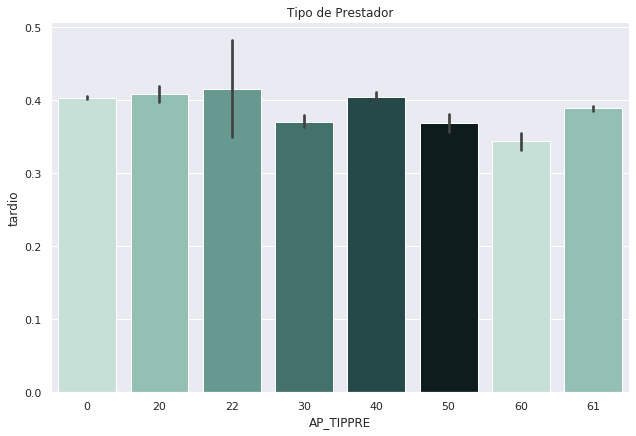

In [36]:
sns.catplot(
    y='tardio', 
    x='AP_TIPPRE', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1.5,
    color='Greens_r',
    palette=palette
)

plt.title('Tipo de Prestador');

#### `AP_MN_IND`

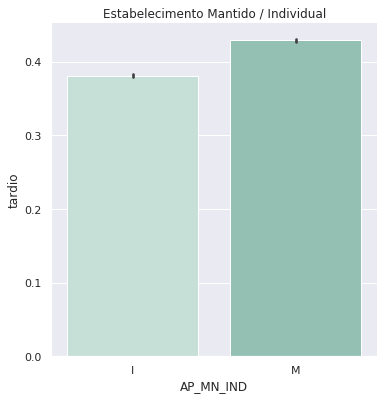

In [37]:
sns.catplot(
    y='tardio', 
    x='AP_MN_IND', 
    kind='bar', 
    data=df, 
    height=5.5,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Estabelecimento Mantido / Individual');

#### `AP_RACACOR`

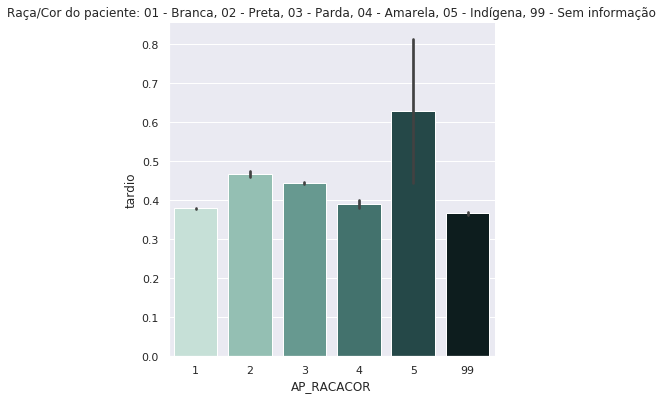

In [38]:
sns.catplot(
    y='tardio', 
    x='AP_RACACOR', 
    kind='bar', 
    data=df, 
    height=5.5,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Raça/Cor do paciente: 01 - Branca, 02 - Preta, 03 - Parda, 04 - Amarela, 05 - Indígena, 99 - Sem informação');

In [39]:
df.AP_RACACOR.value_counts(normalize=True) * 100

1     52.96250
3     26.18250
99    14.71050
2      4.31825
4      1.81950
5      0.00675
Name: AP_RACACOR, dtype: float64

Indígena representa uma parcela bem pequena do dataset, por isso o intervalo de confiança ficou bastante alto comparado com as outras etnias.

#### `AP_UFNACIO`

In [40]:
df.AP_UFNACIO.value_counts().head(10)

10.0    399485
45.0       101
22.0        51
24.0        43
25.0        35
21.0        29
0.0         28
39.0        22
32.0        21
41.0        19
Name: AP_UFNACIO, dtype: int64

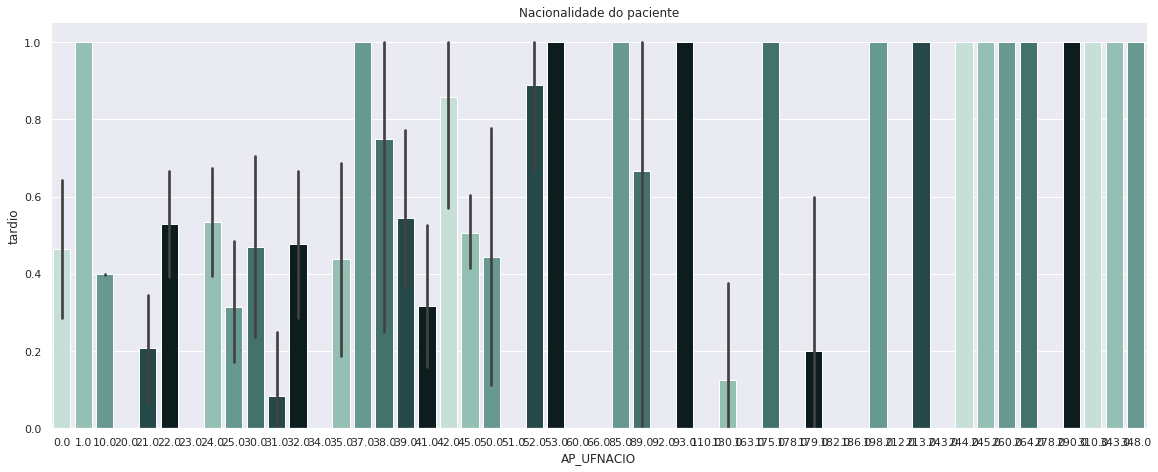

In [41]:
sns.catplot(
    y='tardio', 
    x='AP_UFNACIO', 
    kind='bar', 
    data=df, 
    height=6.5,
    aspect=2.5,
    color='Greens_r',
    palette=palette
)

plt.title('Nacionalidade do paciente');

Essa variável parece não diferenciar diagnóstico tardio de diagnóstico não tardio. Portanto, não será usada no modelo.

#### `AP_TPAPAC`

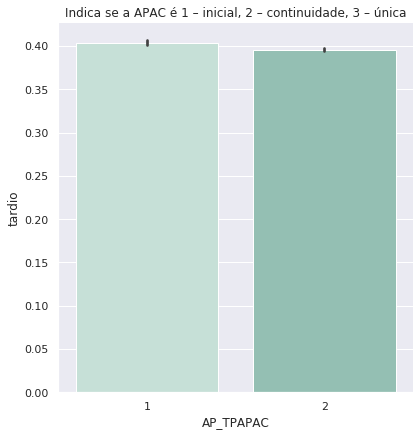

In [42]:
sns.catplot(
    y='tardio', 
    x='AP_TPAPAC', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Indica se a APAC é 1 – inicial, 2 – continuidade, 3 – única');

Essa variável parece não diferenciar diagnóstico tardio de diagnóstico não tardio. Portanto, não será usada no modelo.

#### `AP_CATEND`

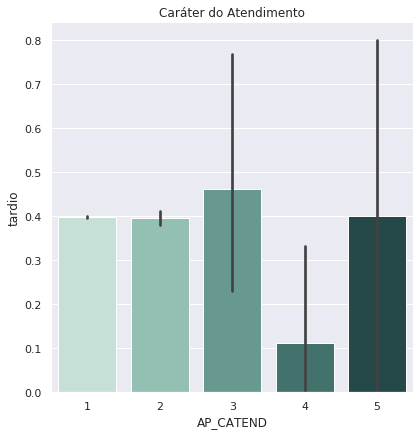

In [43]:
sns.catplot(
    y='tardio', 
    x='AP_CATEND', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Caráter do Atendimento');

Essa variável parece não diferenciar diagnóstico tardio de diagnóstico não tardio. Portanto, não será usada no modelo.

#### `AP_VL_AP`

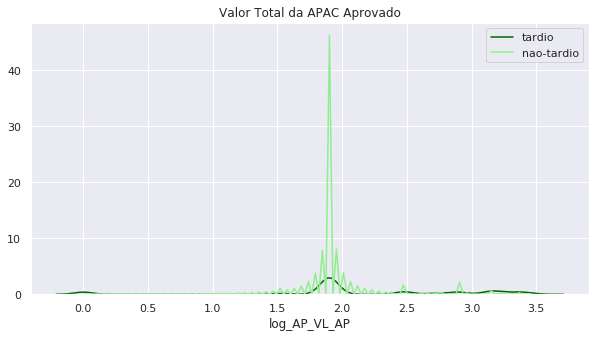

In [45]:
plt.figure(figsize=(10,5))

plot_distplot(
    df=df,
    feature='AP_VL_AP',
    title='Valor Total da APAC Aprovado',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=True,
    target_colors=['darkgreen', 'lightgreen']
)

Parece não haver diferença relevante considerando o valor da APAC.

#### `AP_TPUPS`

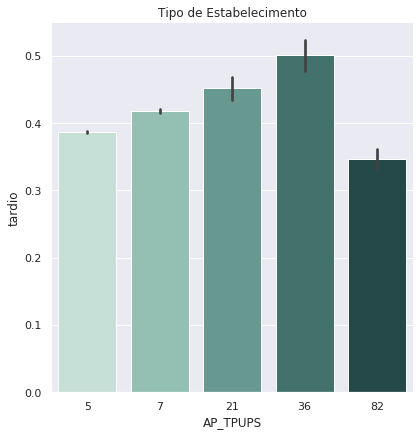

In [46]:
sns.catplot(
    y='tardio', 
    x='AP_TPUPS', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Tipo de Estabelecimento');

#### `AP_ALTA`

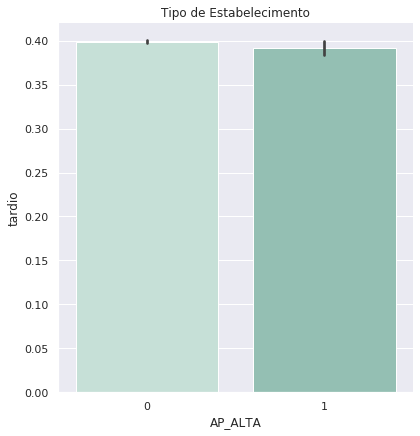

In [47]:
sns.catplot(
    y='tardio', 
    x='AP_ALTA', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Tipo de Estabelecimento');

#### `AQ_TRANTE`

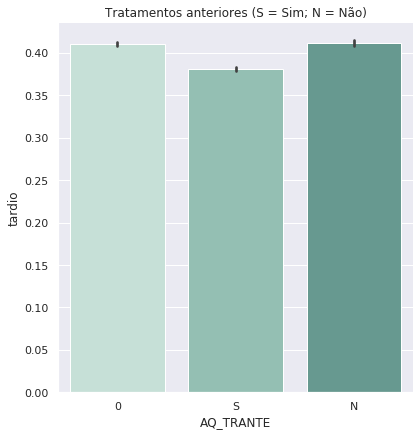

In [48]:
sns.catplot(
    y='tardio', 
    x='AQ_TRANTE', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Tratamentos anteriores (S = Sim; N = Não)');

#### `AQ_CONTTR`

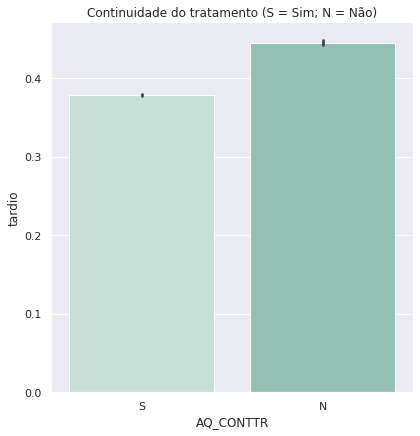

In [49]:
sns.catplot(
    y='tardio', 
    x='AQ_CONTTR', 
    kind='bar', 
    data=df, 
    height=6,
    aspect=1,
    color='Greens_r',
    palette=palette
)

plt.title('Continuidade do tratamento (S = Sim; N = Não)');

### Deteção de tumor ao longo dos anos (Valor absoluto)

In [50]:
df[['AQ_DTIDEN', 'tardio']].head()

,AQ_DTIDEN,tardio
0,20130801,0
1,20140807,0
2,20080717,1
3,20090402,0
4,20171010,1


In [51]:
df.AQ_DTIDEN = df.AQ_DTIDEN.astype(str)

In [52]:
df['AQ_DTIDEN_ANO'] = df.AQ_DTIDEN.apply(lambda x: x[:4])

In [53]:
df.AQ_DTIDEN_ANO = df.AQ_DTIDEN_ANO.astype(int)

In [54]:
tbl_deteccao = df.loc[(df['AQ_DTIDEN_ANO'] > 2010) & (df['AQ_DTIDEN_ANO'] < 2019)][['AQ_DTIDEN_ANO', 'tardio']]

In [55]:
tbl_deteccao = tbl_deteccao[['AQ_DTIDEN_ANO', 'tardio']].groupby(['AQ_DTIDEN_ANO']).sum().reset_index()

In [56]:
tbl_deteccao['tardio_percentage'] = round(100 * (tbl_deteccao['tardio'] / tbl_deteccao.tardio.sum()), 2)

In [57]:
tbl_deteccao

,AQ_DTIDEN_ANO,tardio,tardio_percentage
0,2011,13387,10.36
1,2012,17379,13.44
2,2013,23022,17.81
3,2014,23690,18.33
4,2015,20148,15.59
5,2016,16464,12.74
6,2017,11131,8.61
7,2018,4054,3.14


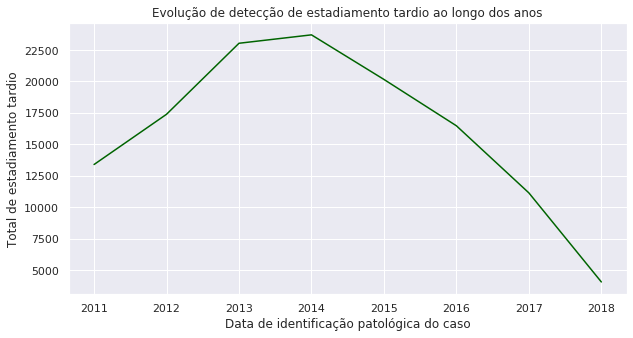

In [58]:
plt.figure(figsize=(10,5))

ax = sns.lineplot(
    x="AQ_DTIDEN_ANO", 
    y="tardio", 
    data=tbl_deteccao,
    color='darkgreen'
)
ax.set_title("Evolução de detecção de estadiamento tardio ao longo dos anos")
ax.set_xlabel("Data de identificação patológica do caso")
ax.set_ylabel("Total de estadiamento tardio");

### Deteção de tumor ao longo dos anos (%)

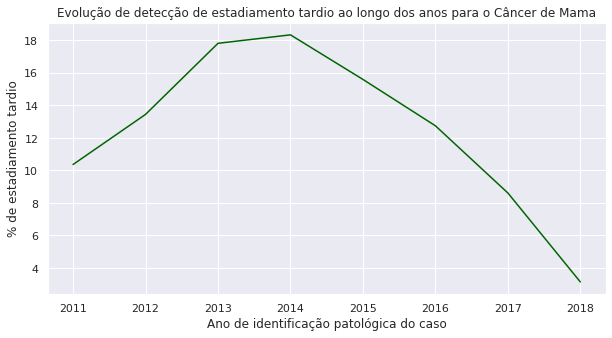

In [59]:
plt.figure(figsize=(10,5))

ax = sns.lineplot(
    x="AQ_DTIDEN_ANO", 
    y="tardio_percentage", 
    data=tbl_deteccao,
    color='darkgreen'
)
ax.set_title("Evolução de detecção de estadiamento tardio ao longo dos anos para o Câncer de Mama")
ax.set_xlabel("Ano de identificação patológica do caso")
ax.set_ylabel("% de estadiamento tardio");

### Idade vs Estadiamento

In [60]:
df[['AP_NUIDADE', 'tardio']].head()

,AP_NUIDADE,tardio
0,57,0
1,59,0
2,43,1
3,91,0
4,58,1


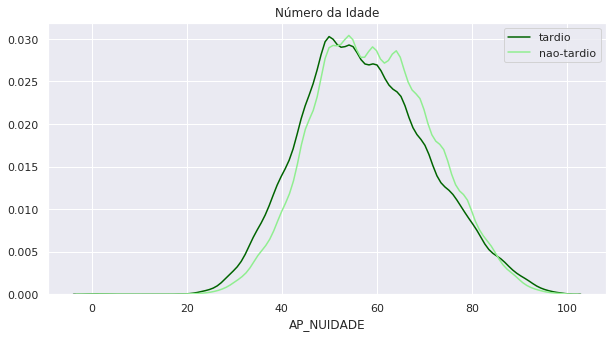

In [61]:
plt.figure(figsize=(10,5))

plot_distplot(
    df=df,
    feature='AP_NUIDADE',
    title='Número da Idade',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=False,
    target_colors=['darkgreen', 'lightgreen']
)

### Função para comparar a evolução média dos recursos ao longo dos anos

In [62]:
def gerar_tabela_recursos(recurso):
    nao_tardio = df.filter(regex=f'^{recurso}|tardio')[df['tardio'] == 0]
    tardio = df.filter(regex=f'^{recurso}|tardio')[df['tardio'] == 1]

    nao_tardio = nao_tardio.filter(regex=f'^{recurso}').mean()
    tardio = tardio.filter(regex=f'^{recurso}').mean()

    num = pd.concat([nao_tardio, tardio], axis=1).reset_index()

    num.rename(columns={'index': 'ano', 0: 'nao_tardio', 1: 'tardio'}, inplace=True)

    num['ano'] = num.ano.apply(lambda x: x[-4:])

    return num

Este gráfico considera a média de recursos para todos os pacientes ao longo dos anos para casos de estadiamento tardio e não tardio. Dessa forma, conseguimos comparar as tendências de ambos os casos.

### Recursos Humanos - Evolução do número de enfermeiros por estadiamento

In [63]:
num_enfermeiros = gerar_tabela_recursos('rh_enfermeiros')

In [64]:
num_enfermeiros

,ano,nao_tardio,tardio
0,2014,2257.443377,2040.143414
1,2015,2425.213135,2186.306461
2,2016,2556.170567,2302.894611
3,2017,2663.782236,2402.233107
4,2018,2822.971971,2544.349827


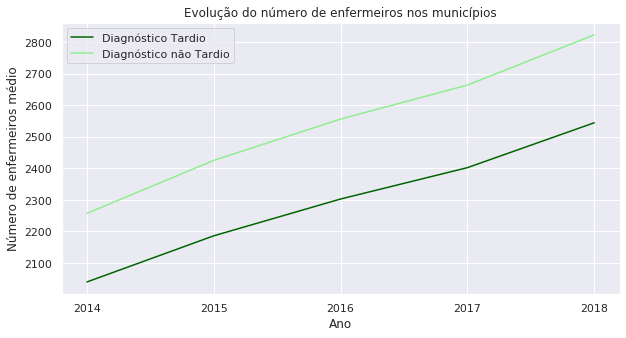

In [65]:
plt.figure(figsize=(10,5))

ax1 = sns.lineplot(x="ano", y="tardio", data=num_enfermeiros, color='darkgreen', label='Diagnóstico Tardio')
ax2 = sns.lineplot(x="ano", y="nao_tardio", data=num_enfermeiros, color='lightgreen', label='Diagnóstico não Tardio')
ax1.set_title("Evolução do número de enfermeiros nos municípios")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Número de enfermeiros médio");

### Recursos Humanos - Evolução do número de médicos por estadiamento

In [66]:
num_medicos = gerar_tabela_recursos('rh_medicos')

In [67]:
num_medicos

,ano,nao_tardio,tardio
0,2014,4615.325921,4119.402812
1,2015,4743.444571,4213.110466
2,2016,4983.999065,4412.165579
3,2017,5137.394144,4559.580837
4,2018,5310.921987,4689.918464


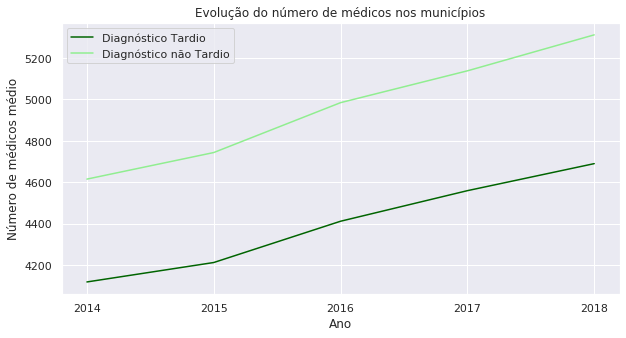

In [68]:
plt.figure(figsize=(10,5))

ax1 = sns.lineplot(x="ano", y="tardio", data=num_medicos, color='darkgreen', label='Diagnóstico Tardio')
ax2 = sns.lineplot(x="ano", y="nao_tardio", data=num_medicos, color='lightgreen', label='Diagnóstico não Tardio')
ax1.set_title("Evolução do número de médicos nos municípios")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Número de médicos médio");

### Recursos Físicos - Evolução do número de leitos por Estadiamento

In [69]:
num_leitos = gerar_tabela_recursos('rf_leitos')

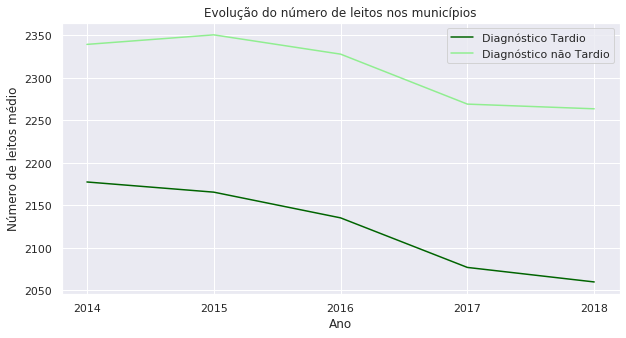

In [70]:
plt.figure(figsize=(10,5))

ax1 = sns.lineplot(x="ano", y="tardio", data=num_leitos, color='darkgreen', label='Diagnóstico Tardio')
ax2 = sns.lineplot(x="ano", y="nao_tardio", data=num_leitos, color='lightgreen', label='Diagnóstico não Tardio')
ax1.set_title("Evolução do número de leitos nos municípios")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Número de leitos médio");

### Recursos Físicos - Evolução do número de mamógrafos por estadiamento

In [71]:
num_mamografos = gerar_tabela_recursos('rf_mamografos')

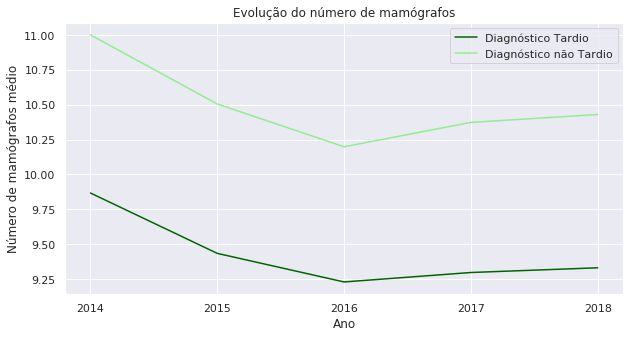

In [72]:
plt.figure(figsize=(10,5))

ax1 = sns.lineplot(x="ano", y="tardio", data=num_mamografos, color='darkgreen', label='Diagnóstico Tardio')
ax2 = sns.lineplot(x="ano", y="nao_tardio", data=num_mamografos, color='lightgreen', label='Diagnóstico não Tardio')
ax1.set_title("Evolução do número de mamógrafos")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Número de mamógrafos médio");

### Recursos Físicos - Evolução do número de Raio-X por estadiamento

In [73]:
num_raio_x = gerar_tabela_recursos('rf_raios_x')

In [74]:
num_raio_x

,ano,nao_tardio,tardio
0,2014,94.088680,85.991913
1,2015,93.926452,85.386038
2,2016,95.012796,86.976078
3,2017,96.747727,88.349065
4,2018,98.733654,90.147351


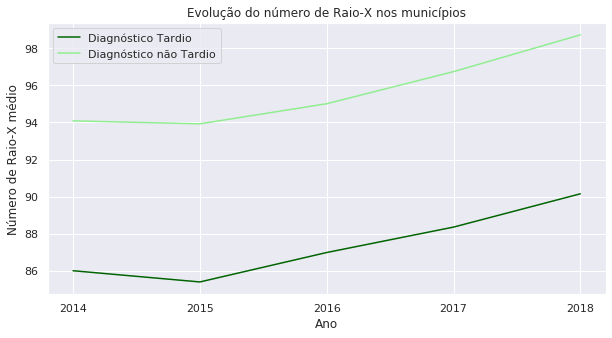

In [75]:
plt.figure(figsize=(10,5))

ax1 = sns.lineplot(x="ano", y="tardio", data=num_raio_x, color='darkgreen', label='Diagnóstico Tardio')
ax2 = sns.lineplot(x="ano", y="nao_tardio", data=num_raio_x, color='lightgreen', label='Diagnóstico não Tardio')
ax1.set_title("Evolução do número de Raio-X nos municípios")
ax1.set_xlabel("Ano")
ax1.set_ylabel("Número de Raio-X médio");

### Estabelecimentos por estadiamento

In [76]:
est = df.filter(regex='(^est_|hosp_|ubs_|dianose|hop_).*2018|tardio').groupby(['tardio']).mean()

In [77]:
est = est.T.reset_index()

In [78]:
est = est.melt(id_vars=['index'])

In [79]:
est.rename(columns={'index': 'Tipo de Estabelecimento', 'tardio': 'Diagnóstico Tardio', 'value': 'Média'}, inplace=True)

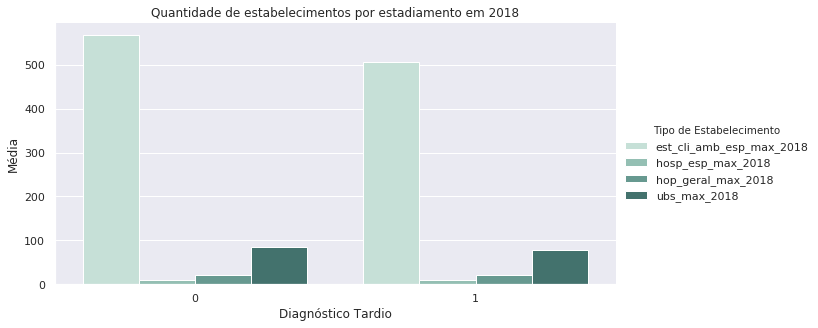

In [80]:
ax = sns.catplot(
    x="Diagnóstico Tardio", 
    y="Média", 
    hue="Tipo de Estabelecimento", 
    kind="bar", 
    height=4.5,
    aspect=2,
    data=est,
    palette=palette
)

plt.title('Quantidade de estabelecimentos por estadiamento em 2018');

### Recursos físicos por estadiamento

In [81]:
rf = df.filter(regex='^rh_.*2018|tardio').groupby(['tardio']).mean()
rf = rf.T.reset_index()
rf = rf.melt(id_vars=['index'])
rf.rename(columns={'index': 'Recursos Humanos', 'tardio': 'Diagnóstico Tardio', 'value': 'Média'}, inplace=True)

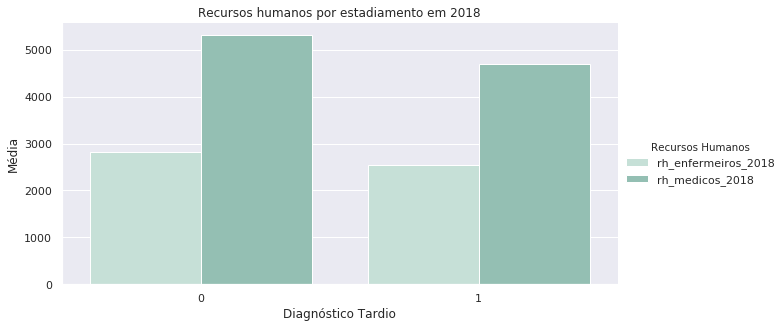

In [82]:
ax = sns.catplot(
    x="Diagnóstico Tardio", 
    y="Média", 
    hue="Recursos Humanos", 
    kind="bar", 
    height=4.5,
    aspect=2,
    data=rf,
    palette=palette
)

plt.title('Recursos humanos por estadiamento em 2018');

### Equipes por estadiamento 

In [83]:
eq = df.filter(regex='^equipes_.*2018|tardio').groupby(['tardio']).mean()
eq = eq.T.reset_index()
eq = eq.melt(id_vars=['index'])
eq.rename(columns={'index': 'Equipes', 'tardio': 'Diagnóstico Tardio', 'value': 'Média'}, inplace=True)

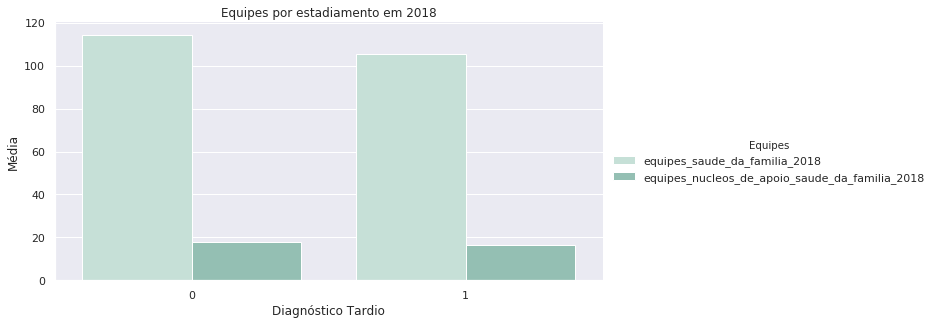

In [84]:
ax = sns.catplot(
    x="Diagnóstico Tardio", 
    y="Média", 
    hue="Equipes", 
    kind="bar", 
    height=4.5,
    aspect=2,
    data=eq,
    palette=palette
)

plt.title('Equipes por estadiamento em 2018');

### Recursos Físicos por estadiamento (Tirando o número de Leitos)

In [85]:
rf = df.filter(regex='^rf_.*2018|tardio').groupby(['tardio']).mean()
rf.drop(columns='rf_leitos_2018', inplace=True)
rf = rf.T.reset_index()
rf = rf.melt(id_vars=['index'])
rf.rename(columns={'index': 'Recursos Físicos', 'tardio': 'Diagnóstico Tardio', 'value': 'Média'}, inplace=True)

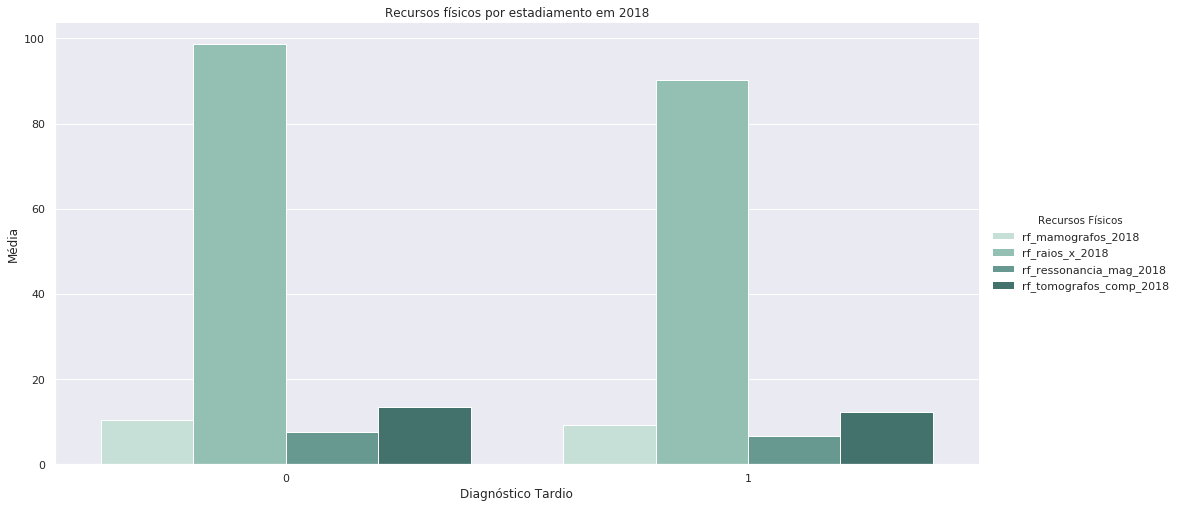

In [86]:
ax = sns.catplot(
    x="Diagnóstico Tardio", 
    y="Média", 
    hue="Recursos Físicos", 
    kind="bar", 
    height=7,
    aspect=2,
    data=rf,
    palette=palette
)

plt.title('Recursos físicos por estadiamento em 2018');

In [87]:
df.head()

,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_UFDIF,AP_MNDIF,AP_TPAPAC,AP_ALTA,AP_CATEND,AP_CIDCAS,AQ_DTIDEN,AQ_TRANTE,AQ_CONTTR,tardio,nome_mun,rh_enfermeiros_2014,rh_enfermeiros_2015,rh_enfermeiros_2016,rh_enfermeiros_2017,rh_enfermeiros_2018,rh_medicos_2014,rh_medicos_2015,rh_medicos_2016,rh_medicos_2017,rh_medicos_2018,rf_leitos_2014,rf_leitos_2015,rf_leitos_2016,rf_leitos_2017,rf_leitos_2018,rf_mamografos_2014,rf_mamografos_2015,rf_mamografos_2016,rf_mamografos_2017,rf_mamografos_2018,rf_raios_x_2014,rf_raios_x_2015,rf_raios_x_2016,rf_raios_x_2017,rf_raios_x_2018,rf_ressonancia_mag_2014,rf_ressonancia_mag_2015,rf_ressonancia_mag_2016,rf_ressonancia_mag_2017,rf_ressonancia_mag_2018,rf_tomografos_comp_2014,rf_tomografos_comp_2015,rf_tomografos_comp_2016,rf_tomografos_comp_2017,rf_tomografos_comp_2018,est_cli_amb_esp_max_2014,est_cli_amb_esp_max_2015,est_cli_amb_esp_max_2016,est_cli_amb_esp_max_2017,est_cli_amb_esp_max_2018,hosp_esp_max_2014,hosp_esp_max_2015,hosp_esp_max_2016,hosp_esp_max_2017,hosp_esp_max_2018,hop_geral_max_2014,hop_geral_max_2015,hop_geral_max_2016,hop_geral_max_2017,hop_geral_max_2018,ubs_max_2014,ubs_max_2015,ubs_max_2016,ubs_max_2017,ubs_max_2018,diagnose_e_terapia_max_2014,diagnose_e_terapia_max_2015,diagnose_e_terapia_max_2016,diagnose_e_terapia_max_2017,diagnose_e_terapia_max_2018,equipes_saude_da_familia_2014,equipes_saude_da_familia_2015,equipes_saude_da_familia_2016,equipes_saude_da_familia_2017,equipes_saude_da_familia_2018,equipes_nucleos_de_apoio_saude_da_familia_2014,equipes_nucleos_de_apoio_saude_da_familia_2015,equipes_nucleos_de_apoio_saude_da_familia_2016,equipes_nucleos_de_apoio_saude_da_familia_2017,equipes_nucleos_de_apoio_saude_da_familia_2018,AQ_DTIDEN_ANO
0,2828.40,355030,7,0,I,57,F,99,355030,10.0,0,1,2,1,1,0000,20130801,0,S,0,São Paulo,18275.0,19692.0,20508.0,21273.0,22376.0,36244.0,37413.0,39489.0,40380.0,41820.0,15238.0,15724.0,15710.0,15174.0,15262.0,71.0,65.0,61.0,64.0,65.0,677.0,680.0,685.0,700.0,712.0,32.0,33.0,33.0,46.0,50.0,63.0,66.0,65.0,78.0,87.0,2377.0,2758.0,3249.0,3705.0,4190.0,52.0,52.0,50.0,51.0,51.0,147.0,151.0,148.0,148.0,151.0,572.0,571.0,498.0,498.0,499.0,664.0,663.0,683.0,786.0,869.0,835.0,788.0,817.0,799.0,887.0,98.0,89.0,100.0,127.0,130.0,2013
1,79.75,330455,7,0,M,59,F,1,330455,10.0,0,1,2,0,1,0,20140807,0,S,0,Rio de Janeiro,11414.0,11957.0,12493.0,13023.0,13548.0,20795.0,20484.0,21185.0,22177.0,21878.0,11530.0,10955.0,10450.0,9873.0,9354.0,30.0,28.0,29.0,27.0,27.0,400.0,380.0,415.0,420.0,423.0,18.0,19.0,21.0,22.0,25.0,46.0,46.0,46.0,45.0,49.0,1763.0,1659.0,1686.0,1874.0,2097.0,104.0,77.0,78.0,77.0,69.0,151.0,122.0,121.0,129.0,129.0,248.0,245.0,274.0,287.0,309.0,717.0,571.0,577.0,570.0,606.0,392.0,388.0,517.0,597.0,596.0,58.0,74.0,73.0,77.0,77.0,2014
2,751.00,211130,7,0,M,43,F,99,210650,10.0,0,1,2,1,1,0,20080717,S,S,1,Matinha,9.0,14.0,13.0,16.0,15.0,15.0,11.0,12.0,13.0,9.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,5.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2008
3,301.50,355220,5,0,M,91,F,3,355220,10.0,0,1,2,0,1,0000,20090402,0,S,0,Sorocaba,575.0,634.0,659.0,678.0,728.0,1594.0,1633.0,1678.0,1769.0,1866.0,1982.0,1456.0,1217.0,983.0,883.0,8.0,8.0,8.0,8.0,8.0,41.0,42.0,45.0,45.0,47.0,1.0,1.0,2.0,2.0,4.0,6.0,7.0,6.0,5.0,6.0,54.0,57.0,62.0,68.0,80.0,7.0,7.0,6.0,4.0,4.0,7.0,7.0,7.0,7.0,8.0,35.0,34.0,35.0,36.0,36.0,75.0,78.0,80.0,85.0,91.0,39.0,38.0,41.0,42.0,43.0,0.0,0.0,0.0,2.0,3.0,2009
4,79.75,350950,5,0,M,58,F,1,355240,10.0,0,1,2,0,1,0000,20171010,0,S,1,Sumaré,181.0,205.0,222.0,215.0,215.0,163.0,169.0,191.0,194.0,201.0,180.0,172.0,172.0,172.0,172.0,3.0,4.0,4.0,4.0,4.0,16.0,18.0,20.0,20.0,21.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,4.0,11.0,13.0,13.0,19.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,25.0,25.0,25.0,25.0,25.0,20.0,22.0,24.0,24.0,23.0,7.0,9.0,

### Função para gerar Score de RF, RH, Estabelecimentos e Equipes

O Score é basicamente uma normalização usando o MinMaxScaler do `sklearn`. Ou seja, o município que tiver a maior quantidade daquele recurso recebe a nota 1 e o que tiver a menor quantidade daquele recurso recebe a nota 0.

In [88]:
def gerar_score(df, tipo):
    df = df.filter(regex=f'^{tipo}|tardio')
    scaler = MinMaxScaler()
    scaler.fit(df[df.columns.tolist()])
    df[df.columns.tolist()] = scaler.transform(df[df.columns.tolist()])
    df['nota_' + tipo] = df.mean(axis=1)
    
    return df

### Score de Recursos Físicos

In [89]:
score_rf = gerar_score(df, 'rf_')

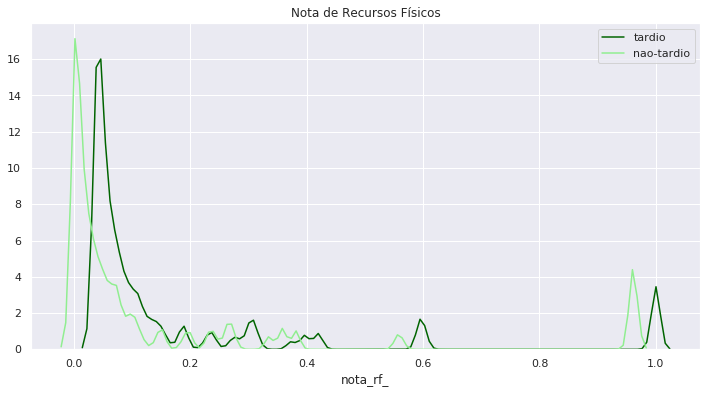

In [90]:
plt.figure(figsize=(12,6))

plot_distplot(
    df=score_rf,
    feature='nota_rf_',
    title='Nota de Recursos Físicos',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=False,
    target_colors=['darkgreen', 'lightgreen']
)

### Score de Recursos Humanos

In [91]:
score_rh = gerar_score(df, 'rh_')

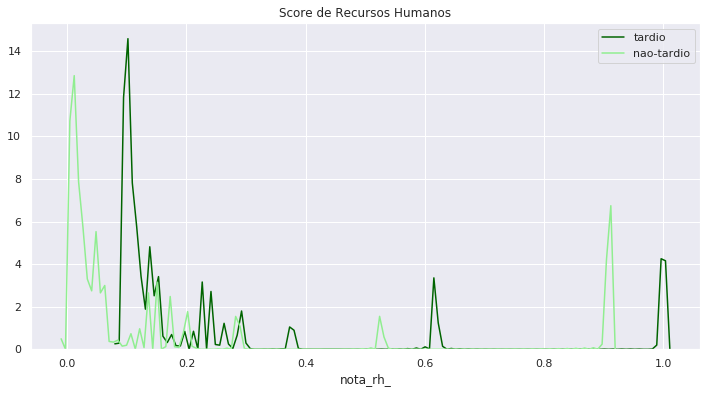

In [92]:
plt.figure(figsize=(12,6))

plot_distplot(
    df=score_rh,
    feature='nota_rh_',
    title='Score de Recursos Humanos',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=False,
    target_colors=['darkgreen', 'lightgreen']
)

### Score de Estabelecimentos

In [93]:
score_est = gerar_score(df, 'est_|hosp_|hop_|ubs_|diagnose_|tardio_')

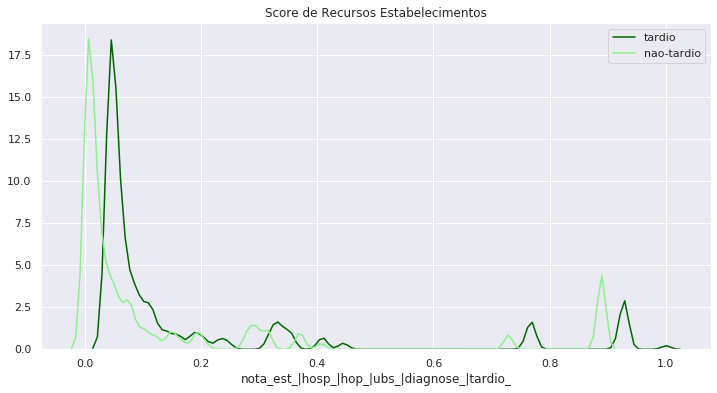

In [94]:
plt.figure(figsize=(12,6))

plot_distplot(
    df=score_est,
    feature='nota_est_|hosp_|hop_|ubs_|diagnose_|tardio_',
    title='Score de Recursos Estabelecimentos',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=False,
    target_colors=['darkgreen', 'lightgreen']
)

### Score de Equipes

In [95]:
score_equipes = gerar_score(df, 'equipes_')

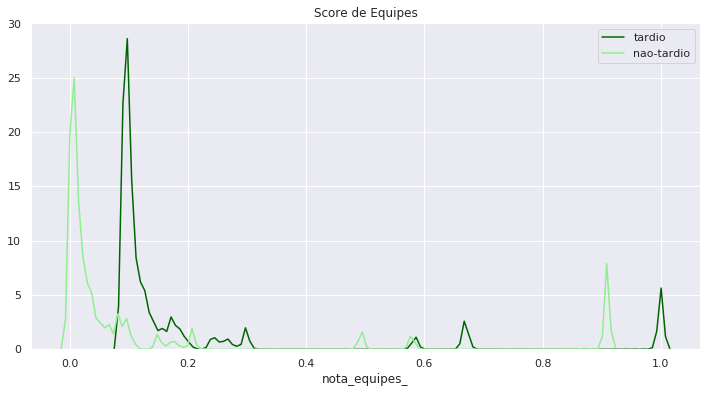

In [96]:
plt.figure(figsize=(12,6))

plot_distplot(
    df=score_equipes,
    feature='nota_equipes_',
    title='Score de Equipes',
    target='tardio',
    target_names=['tardio', 'nao-tardio'],
    log10=False,
    target_colors=['darkgreen', 'lightgreen']
)

### Quais tipos de estabelecimentos são mais importantes para o estadiamento?

| Prefixo            	| Estabelecimento                                                      	|
|--------------------	|----------------------------------------------------------------------	|
| est_cli_amb_esp_    	| Estabelecimentos - Clínicas Ambulatórios Especializados              	|
| hosp_esp_           	| Estabelecimentos - Hospital Especializado                            	|
| hop_geral_          	| Estabelecimentos - Hospital Geral                                    	|
| ubs_                	| Estabelecimentos - Unidade Básica de Saúde                           	|
| diagnose_e_terapia_ 	| Estabelecimentos - Unidade de Serviço de Apoio ao Diagnose e Terapia 	|

In [97]:
df.filter(regex='(^est|hosp|hop|ubs|diagnose|tardio).*2017|tardio').head()

,tardio,est_cli_amb_esp_max_2017,hosp_esp_max_2017,hop_geral_max_2017,ubs_max_2017,diagnose_e_terapia_max_2017
0,0,3705.0,51.0,148.0,498.0,786.0
1,0,1874.0,77.0,129.0,287.0,570.0
2,1,0.0,0.0,1.0,7.0,0.0
3,0,68.0,4.0,7.0,36.0,85.0
4,1,19.0,0.0,2.0,25.0,24.0


In [98]:
est_score = score_est.filter(regex='(^est|hosp|hop|ubs|diagnose|tardio).*2017|tardio').groupby(['tardio']).mean()
est_score = est_score.T.reset_index()
est_score = est_score.melt(id_vars=['index'])
est_score.rename(columns={'index': 'Tipo de Estabelecimento', 'tardio': 'Diagnóstico Tardio', 'value': 'Média'}, inplace=True)

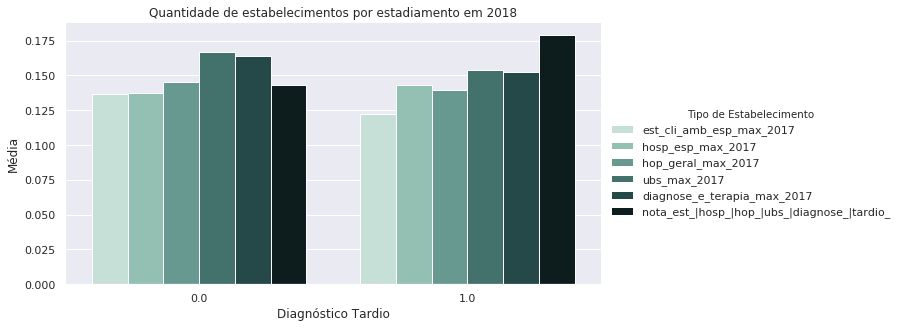

In [99]:
ax = sns.catplot(
    x="Diagnóstico Tardio", 
    y="Média", 
    hue="Tipo de Estabelecimento", 
    kind="bar", 
    height=4.5,
    aspect=2,
    data=est_score,
    palette=palette
)

plt.title('Quantidade de estabelecimentos por estadiamento em 2018');

### Preparação das variáveis para modelagem

In [100]:
print(df.shape)
df.head()

(400000, 92)


,AP_VL_AP,AP_UFMUN,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_UFDIF,AP_MNDIF,AP_TPAPAC,AP_ALTA,AP_CATEND,AP_CIDCAS,AQ_DTIDEN,AQ_TRANTE,AQ_CONTTR,tardio,nome_mun,rh_enfermeiros_2014,rh_enfermeiros_2015,rh_enfermeiros_2016,rh_enfermeiros_2017,rh_enfermeiros_2018,rh_medicos_2014,rh_medicos_2015,rh_medicos_2016,rh_medicos_2017,rh_medicos_2018,rf_leitos_2014,rf_leitos_2015,rf_leitos_2016,rf_leitos_2017,rf_leitos_2018,rf_mamografos_2014,rf_mamografos_2015,rf_mamografos_2016,rf_mamografos_2017,rf_mamografos_2018,rf_raios_x_2014,rf_raios_x_2015,rf_raios_x_2016,rf_raios_x_2017,rf_raios_x_2018,rf_ressonancia_mag_2014,rf_ressonancia_mag_2015,rf_ressonancia_mag_2016,rf_ressonancia_mag_2017,rf_ressonancia_mag_2018,rf_tomografos_comp_2014,rf_tomografos_comp_2015,rf_tomografos_comp_2016,rf_tomografos_comp_2017,rf_tomografos_comp_2018,est_cli_amb_esp_max_2014,est_cli_amb_esp_max_2015,est_cli_amb_esp_max_2016,est_cli_amb_esp_max_2017,est_cli_amb_esp_max_2018,hosp_esp_max_2014,hosp_esp_max_2015,hosp_esp_max_2016,hosp_esp_max_2017,hosp_esp_max_2018,hop_geral_max_2014,hop_geral_max_2015,hop_geral_max_2016,hop_geral_max_2017,hop_geral_max_2018,ubs_max_2014,ubs_max_2015,ubs_max_2016,ubs_max_2017,ubs_max_2018,diagnose_e_terapia_max_2014,diagnose_e_terapia_max_2015,diagnose_e_terapia_max_2016,diagnose_e_terapia_max_2017,diagnose_e_terapia_max_2018,equipes_saude_da_familia_2014,equipes_saude_da_familia_2015,equipes_saude_da_familia_2016,equipes_saude_da_familia_2017,equipes_saude_da_familia_2018,equipes_nucleos_de_apoio_saude_da_familia_2014,equipes_nucleos_de_apoio_saude_da_familia_2015,equipes_nucleos_de_apoio_saude_da_familia_2016,equipes_nucleos_de_apoio_saude_da_familia_2017,equipes_nucleos_de_apoio_saude_da_familia_2018,AQ_DTIDEN_ANO
0,2828.40,355030,7,0,I,57,F,99,355030,10.0,0,1,2,1,1,0000,20130801,0,S,0,São Paulo,18275.0,19692.0,20508.0,21273.0,22376.0,36244.0,37413.0,39489.0,40380.0,41820.0,15238.0,15724.0,15710.0,15174.0,15262.0,71.0,65.0,61.0,64.0,65.0,677.0,680.0,685.0,700.0,712.0,32.0,33.0,33.0,46.0,50.0,63.0,66.0,65.0,78.0,87.0,2377.0,2758.0,3249.0,3705.0,4190.0,52.0,52.0,50.0,51.0,51.0,147.0,151.0,148.0,148.0,151.0,572.0,571.0,498.0,498.0,499.0,664.0,663.0,683.0,786.0,869.0,835.0,788.0,817.0,799.0,887.0,98.0,89.0,100.0,127.0,130.0,2013
1,79.75,330455,7,0,M,59,F,1,330455,10.0,0,1,2,0,1,0,20140807,0,S,0,Rio de Janeiro,11414.0,11957.0,12493.0,13023.0,13548.0,20795.0,20484.0,21185.0,22177.0,21878.0,11530.0,10955.0,10450.0,9873.0,9354.0,30.0,28.0,29.0,27.0,27.0,400.0,380.0,415.0,420.0,423.0,18.0,19.0,21.0,22.0,25.0,46.0,46.0,46.0,45.0,49.0,1763.0,1659.0,1686.0,1874.0,2097.0,104.0,77.0,78.0,77.0,69.0,151.0,122.0,121.0,129.0,129.0,248.0,245.0,274.0,287.0,309.0,717.0,571.0,577.0,570.0,606.0,392.0,388.0,517.0,597.0,596.0,58.0,74.0,73.0,77.0,77.0,2014
2,751.00,211130,7,0,M,43,F,99,210650,10.0,0,1,2,1,1,0,20080717,S,S,1,Matinha,9.0,14.0,13.0,16.0,15.0,15.0,11.0,12.0,13.0,9.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,5.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2008
3,301.50,355220,5,0,M,91,F,3,355220,10.0,0,1,2,0,1,0000,20090402,0,S,0,Sorocaba,575.0,634.0,659.0,678.0,728.0,1594.0,1633.0,1678.0,1769.0,1866.0,1982.0,1456.0,1217.0,983.0,883.0,8.0,8.0,8.0,8.0,8.0,41.0,42.0,45.0,45.0,47.0,1.0,1.0,2.0,2.0,4.0,6.0,7.0,6.0,5.0,6.0,54.0,57.0,62.0,68.0,80.0,7.0,7.0,6.0,4.0,4.0,7.0,7.0,7.0,7.0,8.0,35.0,34.0,35.0,36.0,36.0,75.0,78.0,80.0,85.0,91.0,39.0,38.0,41.0,42.0,43.0,0.0,0.0,0.0,2.0,3.0,2009
4,79.75,350950,5,0,M,58,F,1,355240,10.0,0,1,2,0,1,0000,20171010,0,S,1,Sumaré,181.0,205.0,222.0,215.0,215.0,163.0,169.0,191.0,194.0,201.0,180.0,172.0,172.0,172.0,172.0,3.0,4.0,4.0,4.0,4.0,16.0,18.0,20.0,20.0,21.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,4.0,11.0,13.0,13.0,19.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,25.0,25.0,25.0,25.0,25.0,20.0,22.0,24.0,24.0,23.0,7.0,9.0,

Seleciona variáveis de infraestrutura (Recursos físicos, equipes, estabelecimentos, recursos humanos) na região a qual o paciente mora.

In [101]:
infra_features = df.filter(regex='^rf_|equipes_|rh_|est_|hosp_|ubs_|dianose|hop_').columns.tolist()

Seleciona outras características que foram consideradas mais importantes nas análises das células anteriores

In [105]:
mama_features = ['AP_TPUPS', 'AP_TIPPRE', 'AP_MN_IND', 'AP_NUIDADE', 
                 'AP_SEXO', 'AP_RACACOR', 'AP_UFDIF', 'AQ_TRANTE', 'AQ_CONTTR']

In [106]:
features_for_the_model = infra_features + mama_features

In [107]:
df_model = df[features_for_the_model]

In [108]:
df_model.head()

,rh_enfermeiros_2014,rh_enfermeiros_2015,rh_enfermeiros_2016,rh_enfermeiros_2017,rh_enfermeiros_2018,rh_medicos_2014,rh_medicos_2015,rh_medicos_2016,rh_medicos_2017,rh_medicos_2018,rf_leitos_2014,rf_leitos_2015,rf_leitos_2016,rf_leitos_2017,rf_leitos_2018,rf_mamografos_2014,rf_mamografos_2015,rf_mamografos_2016,rf_mamografos_2017,rf_mamografos_2018,rf_raios_x_2014,rf_raios_x_2015,rf_raios_x_2016,rf_raios_x_2017,rf_raios_x_2018,rf_ressonancia_mag_2014,rf_ressonancia_mag_2015,rf_ressonancia_mag_2016,rf_ressonancia_mag_2017,rf_ressonancia_mag_2018,rf_tomografos_comp_2014,rf_tomografos_comp_2015,rf_tomografos_comp_2016,rf_tomografos_comp_2017,rf_tomografos_comp_2018,est_cli_amb_esp_max_2014,est_cli_amb_esp_max_2015,est_cli_amb_esp_max_2016,est_cli_amb_esp_max_2017,est_cli_amb_esp_max_2018,hosp_esp_max_2014,hosp_esp_max_2015,hosp_esp_max_2016,hosp_esp_max_2017,hosp_esp_max_2018,hop_geral_max_2014,hop_geral_max_2015,hop_geral_max_2016,hop_geral_max_2017,hop_geral_max_2018,ubs_max_2014,ubs_max_2015,ubs_max_2016,ubs_max_2017,ubs_max_2018,equipes_saude_da_familia_2014,equipes_saude_da_familia_2015,equipes_saude_da_familia_2016,equipes_saude_da_familia_2017,equipes_saude_da_familia_2018,equipes_nucleos_de_apoio_saude_da_familia_2014,equipes_nucleos_de_apoio_saude_da_familia_2015,equipes_nucleos_de_apoio_saude_da_familia_2016,equipes_nucleos_de_apoio_saude_da_familia_2017,equipes_nucleos_de_apoio_saude_da_familia_2018,AP_TPUPS,AP_TIPPRE,AP_MN_IND,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_UFDIF,AQ_TRANTE,AQ_CONTTR
0,18275.0,19692.0,20508.0,21273.0,22376.0,36244.0,37413.0,39489.0,40380.0,41820.0,15238.0,15724.0,15710.0,15174.0,15262.0,71.0,65.0,61.0,64.0,65.0,677.0,680.0,685.0,700.0,712.0,32.0,33.0,33.0,46.0,50.0,63.0,66.0,65.0,78.0,87.0,2377.0,2758.0,3249.0,3705.0,4190.0,52.0,52.0,50.0,51.0,51.0,147.0,151.0,148.0,148.0,151.0,572.0,571.0,498.0,498.0,499.0,835.0,788.0,817.0,799.0,887.0,98.0,89.0,100.0,127.0,130.0,7,0,I,57,F,99,0,0,S
1,11414.0,11957.0,12493.0,13023.0,13548.0,20795.0,20484.0,21185.0,22177.0,21878.0,11530.0,10955.0,10450.0,9873.0,9354.0,30.0,28.0,29.0,27.0,27.0,400.0,380.0,415.0,420.0,423.0,18.0,19.0,21.0,22.0,25.0,46.0,46.0,46.0,45.0,49.0,1763.0,1659.0,1686.0,1874.0,2097.0,104.0,77.0,78.0,77.0,69.0,151.0,122.0,121.0,129.0,129.0,248.0,245.0,274.0,287.0,309.0,392.0,388.0,517.0,597.0,596.0,58.0,74.0,73.0,77.0,77.0,7,0,M,59,F,1,0,0,S
2,9.0,14.0,13.0,16.0,15.0,15.0,11.0,12.0,13.0,9.0,17.0,17.0,17.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,6.0,5.0,7.0,7.0,7.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,7,0,M,43,F,99,0,S,S
3,575.0,634.0,659.0,678.0,728.0,1594.0,1633.0,1678.0,1769.0,1866.0,1982.0,1456.0,1217.0,983.0,883.0,8.0,8.0,8.0,8.0,8.0,41.0,42.0,45.0,45.0,47.0,1.0,1.0,2.0,2.0,4.0,6.0,7.0,6.0,5.0,6.0,54.0,57.0,62.0,68.0,80.0,7.0,7.0,6.0,4.0,4.0,7.0,7.0,7.0,7.0,8.0,35.0,34.0,35.0,36.0,36.0,39.0,38.0,41.0,42.0,43.0,0.0,0.0,0.0,2.0,3.0,5,0,M,91,F,3,0,0,S
4,181.0,205.0,222.0,215.0,215.0,163.0,169.0,191.0,194.0,201.0,180.0,172.0,172.0,172.0,172.0,3.0,4.0,4.0,4.0,4.0,16.0,18.0,20.0,20.0,21.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,4.0,11.0,13.0,13.0,19.0,24.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,25.0,25.0,25.0,25.0,25.0,7.0,9.0,10.0,10.0,9.0,1.0,2.0,2.0,2.0,2.0,5,0,M,58,F,1,0,0,S


### Salva base Agregada (Mama + Recursos Humanos + Recursos Físicos + Estabelecimentos + Equipes)

In [ ]:
df_model.to_csv('../data/Banco_Datathon/Banco_Datathon/processed/mama.csv')